In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.constrained_layout.use'] = True

import dask
print(f'dask: {dask.__version__}')
import dask.array
dask.config.set({'array.chunk-size': '512MiB'})

import toolbox_scs as tb
print(tb.__file__)
import toolbox_scs.routines.boz as boz

dask: 2024.1.0
/gpfs/exfel/u/scratch/SCS/202430/p900411/checkouts/toolbox_p900411/src/toolbox_scs/__init__.py


In [2]:
from psutil import virtual_memory

mem = virtual_memory()
print(f'Physical memory: {mem.total/1024/1024/1024:.0f} Gb')  # total physical memory available

import subprocess as sp
import os

def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0])/1024 for i, x in enumerate(memory_free_info)]
    return memory_free_values

print(f'GPU memory: {get_gpu_memory()}Gb')

Physical memory: 252 Gb
GPU memory: [39.4228515625]Gb


In [3]:
import sys
print(sys.executable)

/gpfs/exfel/exp/SCS/202430/p900411/scratch/envs/toolbox_p900411/bin/python


In [4]:
%load_ext autoreload

%autoreload 2

# Create parameters object

In [5]:
exclude_trainId = None
proposal = 5746#900411

darkrun = 179
run = 180
exclude_trainId = 1996768679

# darkrun = 99
# run = 98

#darkrun = 92
#run = 93

module = 15
gain = 2
drop_intra_darks = False
sat_level = 400
rois_th = 0.07
ff_prod_th = 350
ff_ratio_th = 0.75

In [6]:
params = boz.parameters(proposal=proposal, darkrun=darkrun, run=run, module=module, gain=gain, drop_intra_darks=drop_intra_darks)

In [7]:
from extra_data.read_machinery import find_proposal

root = find_proposal(f'p{proposal:06d}')
path = root + f'/usr/processed_runs/r{params.run:04d}/'
print(path)
os.makedirs(path, exist_ok=True)
prefix = f'p{proposal}-r{run}-d{darkrun}-BOZ-Ia'

/gpfs/exfel/exp/SCS/202401/p005746/usr/processed_runs/r0180/


In [8]:
print(params)

proposal:5746 darkrun:179 run:180 module:15 gain:2 ph/bin
drop intra darks:False
mask:None
rois threshold: None
rois: None
flat-field type: plane
flat-field p: None prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexagons: False
enforce mirror symmetry: True
ff alpha: None, max. iter.: None
Fnl: None


# Load data persistently

In [9]:
#params.dask_load_persistently(0.3, 1.5)
params.dask_load_persistently(1, 4)

## Slice the data by trainId if the number of pulses is large

In [10]:
params.arr_dark

dask.array<rechunk-merge, shape=(45, 182, 128, 512), dtype=uint16, chunksize=(22, 182, 128, 512), chunktype=numpy.ndarray>

In [11]:
params.arr

dask.array<rechunk-merge, shape=(180, 182, 128, 512), dtype=uint16, chunksize=(22, 182, 128, 512), chunktype=numpy.ndarray>

In [12]:
if exclude_trainId is not None:
    idx = np.argwhere((params.tid - exclude_trainId) == 0)[0][0]
    print(idx)
    
    params.tid = params.tid[5:]
    params.arr = params.arr[5:]

4


# Use GPU

In [13]:
dask.config.set(scheduler="single-threaded")
params.use_gpu()

# Dark run inspection

The aim is to check dark level and extract bad pixel map.

In [14]:
dark = boz.average_module(params.arr_dark).compute()

In [15]:
pedestal = boz.ensure_on_host(np.mean(dark))
pedestal

array(65.97915385)

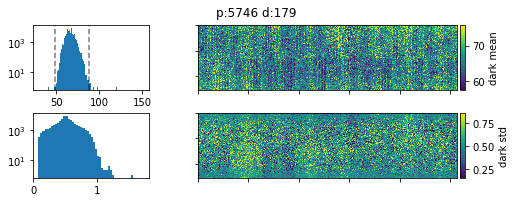

In [16]:
#mean_th = (pedestal-12, pedestal+15)
mean_th = (pedestal-18, pedestal+22) #2.25MHz
f = boz.inspect_dark(boz.ensure_on_host(params.arr_dark),
                     mean_th=mean_th)
f.suptitle(f'p:{params.proposal} d:{params.darkrun}')
fname = path + prefix + '-inspect_dark.png'
f.savefig(fname, dpi=300) 

In [17]:
params.mean_th = mean_th
params.set_mask(boz.bad_pixel_map(params))

# bad pixel: 18


In [18]:
print(params)

proposal:5746 darkrun:179 run:180 module:15 gain:2 ph/bin
drop intra darks:False
mean threshold:(47.979153846675516, 87.97915384667552) std threshold:(None, None)
mask:(#18) [[0, 345], [14, 412], [15, 437], [23, 503], [36, 477], [43, 506], [71, 451], [76, 302], [80, 223], [80, 224], [87, 355], [106, 332], [108, 185], [110, 390], [115, 169], [120, 339], [124, 350], [125, 296]]
rois threshold: None
rois: None
flat-field type: plane
flat-field p: None prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexagons: False
enforce mirror symmetry: True
ff alpha: None, max. iter.: None
Fnl: None


# Veto pattern check

Check potential veto pattern issue

In [19]:
data = boz.average_module(params.arr, dark=dark).compute()
pp = boz.ensure_on_host(data.mean(axis=(1,2))) # pulseId resolved mean
dataM = boz.ensure_on_host(data.mean(axis=0)) # mean over pulseId

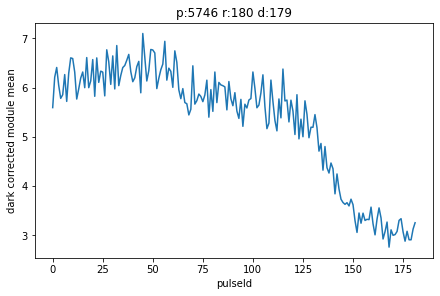

In [20]:
plt.figure()
plt.plot(pp)
plt.xlabel('pulseId')
plt.ylabel('dark corrected module mean')
plt.title(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')
plt.savefig(path+prefix+'-veto_inspect.png', dpi=300)

In [21]:
# Thresholding out bad veto pulse
"""
threshold = 5
if False:
    params.arr = params.arr[:, pp > threshold, :, :]
    params.arr_dark = params.arr_dark[:, pp > threshold, :, :]
    dark = boz.average_module(params.arr_dark).compute()
    data = boz.average_module(params.arr, dark=dark).compute()
    dataM = data.mean(axis=0) # mean over pulseId
"""

'\nthreshold = 5\nif False:\n    params.arr = params.arr[:, pp > threshold, :, :]\n    params.arr_dark = params.arr_dark[:, pp > threshold, :, :]\n    dark = boz.average_module(params.arr_dark).compute()\n    data = boz.average_module(params.arr, dark=dark).compute()\n    dataM = data.mean(axis=0) # mean over pulseId\n'

# Histogram

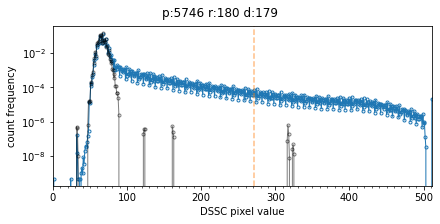

In [22]:
h, f = boz.inspect_histogram(boz.ensure_on_host(params.arr),
                             boz.ensure_on_host(params.arr_dark),
                             mask=boz.ensure_on_host(params.get_mask())
                             #, extra_lines=True
                         )
f.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')
f.savefig(path+prefix+'-histogram.png', dpi=300)

# ROIs extraction

In [23]:
params.rois_th = rois_th
params.rois = boz.find_rois_from_params(params)

In [24]:
print(params)

proposal:5746 darkrun:179 run:180 module:15 gain:2 ph/bin
drop intra darks:False
mean threshold:(47.979153846675516, 87.97915384667552) std threshold:(None, None)
mask:(#18) [[0, 345], [14, 412], [15, 437], [23, 503], [36, 477], [43, 506], [71, 451], [76, 302], [80, 223], [80, 224], [87, 355], [106, 332], [108, 185], [110, 390], [115, 169], [120, 339], [124, 350], [125, 296]]
rois threshold: 0.07
rois: {'n': {'xl': 44, 'xh': 95, 'yl': 40, 'yh': 91}, '0': {'xl': 96, 'xh': 137, 'yl': 40, 'yh': 91}, 'p': {'xl': 215, 'xh': 220, 'yl': 40, 'yh': 91}, 'sat': {'xl': 44, 'xh': 220, 'yl': 40, 'yh': 91}}
flat-field type: plane
flat-field p: None prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexagons: False
enforce mirror symmetry: True
ff alpha: None, max. iter.: None
Fnl: None


In [25]:
#clip ROIs to check if beam clipping occurs
#for beam in ['n', '0', 'p']:
#    params.rois[beam]['xl'] += 15
#    params.rois[beam]['xh'] -= 15
#    params.rois[beam]['yl'] += 15
#    params.rois[beam]['yh'] -= 15

In [26]:
#w = params.rois['0']['xh'] - params.rois['0']['xl']
#params.rois['n']['xl'] = params.rois['n']['xh'] - w
#params.rois['p']['xh'] = params.rois['p']['xl'] + w

# full ROIs
for r in ['n', 'p', '0', 'sat']:
    params.rois[r]['yl'] = 58
    params.rois[r]['yh'] = 94

## Reduced ROIs vertically
#for r in ['n', 'p', '0', 'sat']:
#    params.rois[r]['yl'] = 58+10
#    params.rois[r]['yh'] = 94-2

params.rois['sat']['xl'] = 25
params.rois['n']['xl'] = 27
params.rois['n']['xh'] = 98
params.rois['0']['xl'] = 98
params.rois['0']['xh'] = 169
params.rois['p']['xl'] = 169
params.rois['p']['xh'] = 240
params.rois['sat']['xh'] = 242

In [27]:
for r in ['n', 'p', '0', 'sat']:
    b = params.rois[r]
    print(f"{r}: {b['xh'] - b['xl']}")

n: 71
p: 71
0: 71
sat: 217


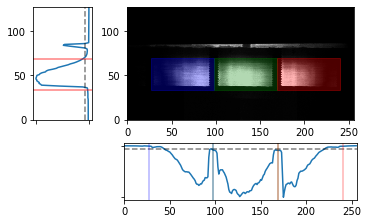

In [28]:
f = boz.inspect_rois(dataM, params.rois, params.rois_th)
f.savefig(path+prefix+f'-rois.png', dpi=300)

# Flat field extraction

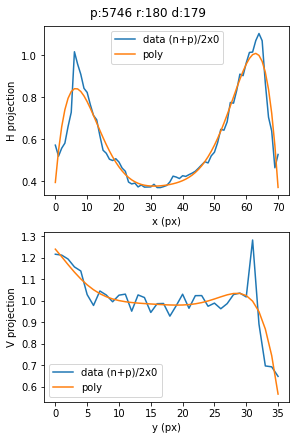

In [29]:
fig = boz.initialize_polyline_ff_correction(dataM, params.rois, params, plot=True)
fig.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')
fig.savefig(path+prefix+f'-polyline-projection.png', dpi=300)

In [30]:
params.get_flat_field()

array([-1.70374285e-03,  3.50954400e-02, -2.82524014e-01,  1.12323395e+00,
       -2.21253039e+00,  1.72226687e+00,  3.95017009e-01, -1.91426059e-02,
        1.64863178e-01, -5.20786105e-01,  7.00215032e-01, -2.25119198e-01,
       -3.39737253e-01,  1.24067098e+00])

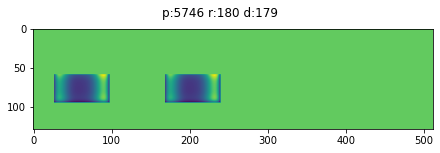

In [31]:
ff = boz.compute_flat_field_correction(params.rois, params)
plt.figure(figsize=(6,2))
plt.imshow(ff)
plt.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')
plt.savefig(path+prefix+f'-polynorm-ff.png', dpi=300)

Text(0.5, 0.98, 'p:5746 r:180 d:179')

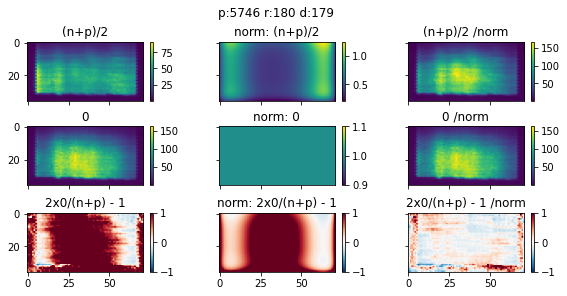

In [32]:
f = boz.inspect_ff_fitting_sk(boz.ensure_on_host(dataM), params.rois, ff)
plt.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')

The first step is to compute a good average image, this mean remove saturated shots and ignoring bad pixels

In [33]:
params.sat_level = sat_level
res = boz.average_module(params.arr, dark=dark,
                         ret='mean', mask=params.get_mask(), sat_roi=params.rois['sat'],
                         sat_level=params.sat_level)
avg = res.mean(axis=0).compute()

The second step is from that good average image to fit the plane field on n/0 and p/0 rois. We have to make sure that the rois have same width.

In [34]:
# default values
params.flat_field_prod_th = (5.0, np.PINF)
params.flat_field_ratio_th = (np.NINF, 1.2)
params.use_hex = False
params.force_mirror = False
params.ff_alpha = 0.1
params.ff_max_iter = 25

print(params)

proposal:5746 darkrun:179 run:180 module:15 gain:2 ph/bin
drop intra darks:False
mean threshold:(47.979153846675516, 87.97915384667552) std threshold:(None, None)
mask:(#18) [[0, 345], [14, 412], [15, 437], [23, 503], [36, 477], [43, 506], [71, 451], [76, 302], [80, 223], [80, 224], [87, 355], [106, 332], [108, 185], [110, 390], [115, 169], [120, 339], [124, 350], [125, 296]]
rois threshold: 0.07
rois: {'n': {'xl': 27, 'xh': 98, 'yl': 58, 'yh': 94}, '0': {'xl': 98, 'xh': 169, 'yl': 58, 'yh': 94}, 'p': {'xl': 169, 'xh': 240, 'yl': 58, 'yh': 94}, 'sat': {'xl': 25, 'xh': 242, 'yl': 58, 'yh': 94}}
flat-field type: polyline
flat-field p: [-0.0017037428505442531, 0.03509543996950445, -0.28252401358896434, 1.1232339460395468, -2.212530386376008, 1.7222668684623201, 0.395017008970426, -0.019142605916517917, 0.16486317776186016, -0.5207861049014739, 0.7002150319121965, -0.22511919830619642, -0.339737252631951, 1.2406709775853386] prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexag

In [35]:
#params.set_flat_field([0, 0, 1, -1, 0, 0, 1, -1])
params.set_Fnl(np.arange(2**9))
params.save(path=path)

/gpfs/exfel/exp/SCS/202401/p005746/usr/processed_runs/r0180/parameters_p5746_d179_r180.json


## Refining flat field

In [36]:
print(params)

proposal:5746 darkrun:179 run:180 module:15 gain:2 ph/bin
drop intra darks:False
mean threshold:(47.979153846675516, 87.97915384667552) std threshold:(None, None)
mask:(#18) [[0, 345], [14, 412], [15, 437], [23, 503], [36, 477], [43, 506], [71, 451], [76, 302], [80, 223], [80, 224], [87, 355], [106, 332], [108, 185], [110, 390], [115, 169], [120, 339], [124, 350], [125, 296]]
rois threshold: 0.07
rois: {'n': {'xl': 27, 'xh': 98, 'yl': 58, 'yh': 94}, '0': {'xl': 98, 'xh': 169, 'yl': 58, 'yh': 94}, 'p': {'xl': 169, 'xh': 240, 'yl': 58, 'yh': 94}, 'sat': {'xl': 25, 'xh': 242, 'yl': 58, 'yh': 94}}
flat-field type: polyline
flat-field p: [-0.0017037428505442531, 0.03509543996950445, -0.28252401358896434, 1.1232339460395468, -2.212530386376008, 1.7222668684623201, 0.395017008970426, -0.019142605916517917, 0.16486317776186016, -0.5207861049014739, 0.7002150319121965, -0.22511919830619642, -0.339737252631951, 1.2406709775853386] prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexag

In [37]:
params.get_flat_field()

array([-1.70374285e-03,  3.50954400e-02, -2.82524014e-01,  1.12323395e+00,
       -2.21253039e+00,  1.72226687e+00,  3.95017009e-01, -1.91426059e-02,
        1.64863178e-01, -5.20786105e-01,  7.00215032e-01, -2.25119198e-01,
       -3.39737253e-01,  1.24067098e+00])

In [38]:
res, cb = boz.ff_refine_fit(params, boz.ff_refine_crit_sk)

0: 0:00:00.000001 (reg. term: 0.6364482075197957, 28.517923869619498, err. term: 279.45120482851684), [-1.70374285e-03  3.50954400e-02 -2.82524014e-01  1.12323395e+00
 -2.21253039e+00  1.72226687e+00  3.95017009e-01 -1.91426059e-02
  1.64863178e-01 -5.20786105e-01  7.00215032e-01 -2.25119198e-01
 -3.39737253e-01  1.24067098e+00]
1: 0:00:13.736765 (reg. term: 1.252209175122964, 28.42354119673923, err. term: 272.9655293912856), [-1.70293142e-03  3.50954957e-02 -2.82524025e-01  1.12323394e+00
 -2.21253039e+00  1.72226687e+00  3.95017009e-01 -1.91426853e-02
  1.64863149e-01 -5.20786116e-01  7.00215028e-01 -2.25119200e-01
 -3.39737253e-01  1.24067098e+00]
2: 0:00:22.125090 (reg. term: 0.4000252429867073, 24.863626611001113, err. term: 245.03603892313075), [-1.69573110e-03  3.50593026e-02 -2.82539771e-01  1.12322866e+00
 -2.21253204e+00  1.72226635e+00  3.95016844e-01 -1.91764719e-02
  1.64850811e-01 -5.20790674e-01  7.00213328e-01 -2.25119834e-01
 -3.39737481e-01  1.24067091e+00]
3: 0:00:43

In [39]:
res.x

array([-1.78795052e-03,  3.62276221e-02, -2.86752651e-01,  1.12572587e+00,
       -2.20852114e+00,  1.72563339e+00,  3.97697674e-01, -1.91691508e-02,
        1.63630215e-01, -5.19035465e-01,  7.02986313e-01, -2.22497619e-01,
       -3.37539914e-01,  1.24261503e+00])

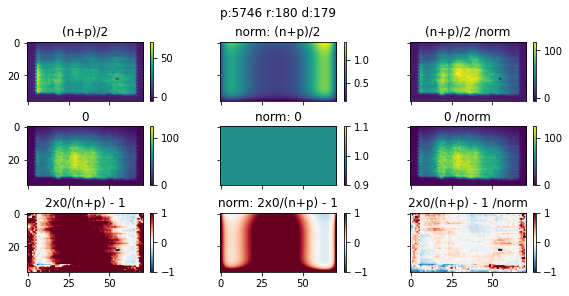

In [40]:
params.set_flat_field(res.x, params.ff_type)
ff = boz.compute_flat_field_correction(params.rois, params)
f = boz.inspect_ff_fitting_sk(boz.ensure_on_host(avg), params.rois, ff)
f.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')
f.savefig(path+prefix+'-inspect-withflatfield-refined.png', dpi=300)

# Non-linearities correction extraction

To speed up online analysis, we save the corrections with a dummy non-linearity correction. The saved file can be used for online analysis as soon as it appears.

In [41]:
params.set_Fnl(np.arange(2**9))
params.save(path=path)

/gpfs/exfel/exp/SCS/202401/p005746/usr/processed_runs/r0180/parameters_p5746_d179_r180.json


In [42]:
N = 80
domain = boz.nl_domain(N, 40, 511)
params.nl_alpha = 0.5
params.nl_max_iter = 25

## minimizing

In [43]:
res, fit_res = boz.nl_fit(params, domain, ff, boz.nl_crit_sk)

0: 0:00:00.000001 (4102.644512978777, 2051.3222564893886, 0.0), [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
1: 0:00:35.919397 (3024.422254096365, 1515.2429208009826, 6.0635875055999096), [ 8.20818406e-04 -2.22427901e-03  1.12560650e-02  4.26314485e-01
  1.91982766e-01 -6.51932016e-01 -4.92832091e-01 -2.25197092e-01
 -4.16688559e-02  8.24781353e-02  1.08187158e-01  1.05635840e-01
  1.08725626e-01  9.70301513e-02  7.22590385e-02  6.98605750e-02
  7.26550004e-02  5.56072777e-02  5.71656497e-02  4.41775122e-02
  4.28982833e-02  2.86748488e-02  2.47899322e-02  1.99975738e-02
  1.34507838e-02  7.46433724e-03  1.69422196e-03 -1.97672339e-03
 -6.85128764e-03 -6.51311493e-03 -9.90331370e-03 -1.34835209e-02
 -1.25454600e-02 -1.58488540e-02 -1.38353089e-02 -1.60964096e-02
 -1.26775280e-02 -1.42788334e-02 -1.24303355e-02 -1.41203518e-02
 -1.12332822e-02 -1.02904408e-02 -8.9872187

7: 0:03:36.738129 (2689.490279116485, 1398.8510576717815, 108.21183622707825), [-3.54379193e-03  1.49734201e-03 -3.49419066e-01 -1.47082664e+00
 -1.04708911e+00 -1.00476814e+00 -1.50668579e+00 -1.00947050e+00
 -2.20960257e-01  3.25553432e-02  7.65545274e-02  1.98688220e-01
  3.72042048e-01  3.48949326e-01  1.52443439e-01  2.89072299e-01
  4.64078029e-01  4.67508370e-01  6.89132494e-01  8.31408047e-01
  1.07268153e+00  1.02019461e+00  9.97748501e-01  1.05557931e+00
  9.93608965e-01  9.16183442e-01  6.70635966e-01  5.15280283e-01
  4.11475560e-01  2.08341544e-01  1.48421348e-01  3.32995836e-02
 -5.06933741e-02 -1.82276806e-01 -2.14130506e-01 -3.18112753e-01
 -3.26904897e-01 -3.65915155e-01 -3.34838856e-01 -4.47209279e-01
 -3.74153144e-01 -3.69606677e-01 -3.32666743e-01 -3.02686468e-01
 -3.42367365e-01 -2.69901554e-01 -2.72927570e-01 -2.02789848e-01
 -1.89464861e-01 -1.35539776e-01 -1.18915426e-01 -8.82486915e-02
 -5.66895203e-02 -4.30713273e-02 -3.32567625e-02 -2.08228928e-02
 -1.4222834

13: 0:06:19.931050 (2683.071079544007, 1396.9455957499117, 110.82011195581657), [-3.95154275e-03  8.07355102e-04 -3.63654280e-01 -1.51990600e+00
 -1.03337225e+00 -1.09669726e+00 -1.49044849e+00 -1.04851271e+00
 -2.74136356e-01 -1.94804190e-02  9.84551705e-02  2.15364672e-01
  3.77718369e-01  3.46162836e-01  1.75401756e-01  3.24466808e-01
  5.24917579e-01  5.14642162e-01  7.26722217e-01  8.49787432e-01
  1.06797671e+00  1.00636007e+00  9.68777456e-01  1.02405525e+00
  9.70051509e-01  9.04372265e-01  6.70072452e-01  5.27786405e-01
  4.34823553e-01  2.17354370e-01  1.79809126e-01  7.05266418e-02
 -1.90560004e-02 -1.48772581e-01 -1.89949200e-01 -2.96369110e-01
 -3.17797391e-01 -3.56552070e-01 -3.29996077e-01 -4.49273567e-01
 -3.79299416e-01 -3.78789521e-01 -3.43316874e-01 -3.01312682e-01
 -3.58266988e-01 -2.84057786e-01 -2.88964788e-01 -2.15713218e-01
 -2.02673264e-01 -1.45635111e-01 -1.18609559e-01 -9.56403400e-02
 -6.18404421e-02 -4.72669770e-02 -3.64279358e-02 -2.29766587e-02
 -1.551211

19: 0:09:20.973437 (2683.2664007426797, 1396.9130593161706, 110.55971788966161), [-5.60458430e-03 -5.45316758e-04 -3.61475748e-01 -1.50936596e+00
 -1.02671922e+00 -1.08859777e+00 -1.49306131e+00 -1.02605942e+00
 -2.93341957e-01  7.37676488e-03  8.96447794e-02  2.09537160e-01
  3.83584194e-01  3.62126661e-01  1.83251443e-01  3.27480945e-01
  5.19346503e-01  5.08399625e-01  7.18017826e-01  8.45969189e-01
  1.06372222e+00  1.05564499e+00  9.67347564e-01  1.02401202e+00
  9.70293489e-01  9.03135281e-01  6.62491125e-01  5.18695807e-01
  4.18431083e-01  2.51189606e-01  1.68044460e-01  5.72599503e-02
 -2.68320442e-02 -1.54652849e-01 -1.91434166e-01 -2.95193768e-01
 -3.31230795e-01 -3.51522536e-01 -3.22037822e-01 -4.43150725e-01
 -3.72861667e-01 -3.73766457e-01 -3.38693198e-01 -3.42855576e-01
 -3.57232939e-01 -2.83884189e-01 -2.89808285e-01 -2.17370313e-01
 -2.03806004e-01 -1.46714084e-01 -1.43077521e-01 -9.69100850e-02
 -6.22687070e-02 -4.74118651e-02 -3.68014780e-02 -2.31519570e-02
 -1.57859

25: 0:12:22.046040 (2683.263294362126, 1396.913054683528, 110.56281500492955), [-5.57266630e-03 -5.20495178e-04 -3.61502688e-01 -1.50950230e+00
 -1.02679208e+00 -1.08869063e+00 -1.49302563e+00 -1.02628634e+00
 -2.93257552e-01  7.36689823e-03  8.93938261e-02  2.09739388e-01
  3.83529807e-01  3.61853466e-01  1.83142399e-01  3.27521568e-01
  5.19519560e-01  5.08421131e-01  7.17982893e-01  8.45942037e-01
  1.06379944e+00  1.05476563e+00  9.67537315e-01  1.02416252e+00
  9.70396432e-01  9.03176055e-01  6.62514879e-01  5.18669915e-01
  4.18484200e-01  2.51010905e-01  1.68037128e-01  5.73204291e-02
 -2.67843217e-02 -1.54634700e-01 -1.91411912e-01 -2.95210610e-01
 -3.31193084e-01 -3.51567633e-01 -3.22141332e-01 -4.43173612e-01
 -3.72922900e-01 -3.73783878e-01 -3.38724224e-01 -3.42959786e-01
 -3.57178916e-01 -2.83839928e-01 -2.89746955e-01 -2.17293536e-01
 -2.03747403e-01 -1.46647952e-01 -1.43163262e-01 -9.68641112e-02
 -6.22398899e-02 -4.73851650e-02 -3.67859333e-02 -2.31326394e-02
 -1.5774989

In [44]:
params.set_Fnl(boz.nl_lut(domain, res.x))

In [45]:
print(params)

proposal:5746 darkrun:179 run:180 module:15 gain:2 ph/bin
drop intra darks:False
mean threshold:(47.979153846675516, 87.97915384667552) std threshold:(None, None)
mask:(#18) [[0, 345], [14, 412], [15, 437], [23, 503], [36, 477], [43, 506], [71, 451], [76, 302], [80, 223], [80, 224], [87, 355], [106, 332], [108, 185], [110, 390], [115, 169], [120, 339], [124, 350], [125, 296]]
rois threshold: 0.07
rois: {'n': {'xl': 27, 'xh': 98, 'yl': 58, 'yh': 94}, '0': {'xl': 98, 'xh': 169, 'yl': 58, 'yh': 94}, 'p': {'xl': 169, 'xh': 240, 'yl': 58, 'yh': 94}, 'sat': {'xl': 25, 'xh': 242, 'yl': 58, 'yh': 94}}
flat-field type: polyline
flat-field p: [-0.0017879505162705697, 0.03622762212160445, -0.2867526509210862, 1.1257258709638456, -2.208521140223112, 1.725633391505318, 0.39769767379472987, -0.01916915078309891, 0.16363021519261778, -0.5190354645772358, 0.7029863125117496, -0.2224976194626101, -0.33753991376726833, 1.2426150264784828] prod:(5.0, inf) ratio:(-inf, 1.2)
plane guess fit: None
use hexag

mu: 0.53162150872741, s: 0.014231833871156006, snr: 37.3543925217438
weighted mu: 0.5284967114811245, s: 0.012979917063851683, snr: 40.716493709575175
diff mu: 0.53162150872741, s: 0.011395944875551761, snr: 46.65005969517471
mu: 0.9811092465797666, s: 0.00778191965332935, snr: 126.07547883895425
weighted mu: 0.9793382676687146, s: 0.00640518892225575, snr: 152.89763964117637
diff mu: 0.9811092465797666, s: 0.007376600692892246, snr: 133.00289488695228
mu: 0.981551672844284, s: 0.006482769558848448, snr: 151.40931108750374
weighted mu: 0.9816293507472074, s: 0.005180022484856727, snr: 189.5029130890651
diff mu: 0.981551672844284, s: 0.006211783906178405, snr: 158.01445891702812


Text(0.5, 0.98, 'p:5746 r:180 d:179')

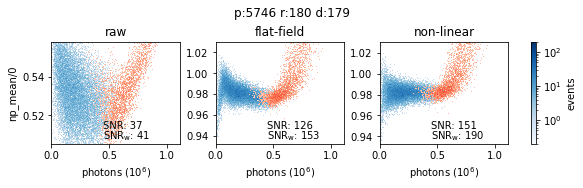

In [46]:
f = boz.inspect_correction_sk(params, ff, gain=params.gain)
f.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')

In [47]:
f.savefig(path+prefix+'-inspect-correction.png', dpi=300)

### plotting the fitted correction

Text(0.5, 0.98, 'p:5746 r:180 d:179')

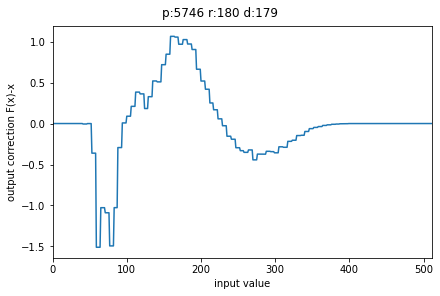

In [48]:
f = boz.inspect_Fnl(boz.ensure_on_host(params.get_Fnl()))
f.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')

In [49]:
f.savefig(path+prefix+'-inspect-Fnl.png', dpi=300)

### plotting the fit progresion

Text(0.5, 0.98, 'p:5746 r:180 d:179')

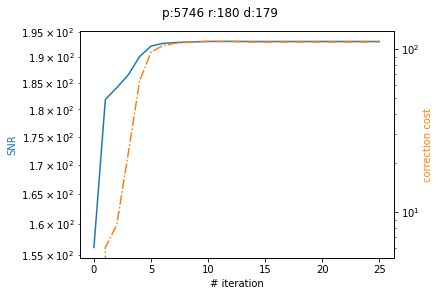

In [50]:
f = boz.inspect_nl_fit(fit_res)
f.suptitle(f'p:{params.proposal} r:{params.run} d:{params.darkrun}')

In [51]:
f.savefig(path+prefix+'-inspect-nl-fit.png', dpi=300)

# Save the analysis parameters

In [52]:
params.save(path=path)

/gpfs/exfel/exp/SCS/202401/p005746/usr/processed_runs/r0180/parameters_p5746_d179_r180.json
